# Sentiment Analysis

In [9]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

#import numpy as numpy
import random
import pickle
from collections import Counter
import codecs
import tensorflow as tf
import np
import time

import os
from os.path import join, exists

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

#nltk.download('punkt')
#nltk.download('wordnet')
#totalLinesToRead = 100
#lemmatizer = WordNetLemmatizer()

# Data load

The first step when building machine learning model is getting your data into the proper form to feed into the model. 


In [10]:
with open('./data/netflix-train-pos', 'r') as f:
    positive_train_txt = f.read()
with open('./data/netflix-train-neg', 'r') as f:
    negative_train_txt = f.read()

In [11]:
print("The positive data size: {}".format(len(positive_train_txt)))
print("The negative data size: {}".format(len(negative_train_txt)))

The positive data size: 16855330
The negative data size: 16302491


# Download GloVe


In [12]:
data_folder = './datasets'
glove = 'glove.6B'
glove_filename = glove + '.zip'
glove_url = 'http://nlp.stanford.edu/data/' + glove_filename
embedding_dim = 300
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, glove + '.' + str(embedding_dim) + 'd.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Download glove.6B.zip
862191616/862182613 [==============================] - 801s 1us/step
Extract ./datasets/glove.6B.300d.txt
Embeddings size: 400000


# Data preprocessing

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [13]:
from string import punctuation

def get_reviews(text):
    #all_text = ''.join([c for c in text if c not in punctuation])
    reviews = text.split('\n')
    return reviews[:1000] # TAKE first 1000 to make it fast

positive_train = get_reviews(positive_train_txt)
negative_train = get_reviews(negative_train_txt)

positive_label = np.full((len(positive_train), 2), [1, 0])
negative_label = np.full((len(negative_train), 2), [0, 1])

train = np.concatenate((positive_train, negative_train), axis=0)
labels = np.concatenate((positive_label, negative_label), axis=0)

# shuffle
c = np.c_[train.reshape(len(train), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train = c[:, :train.size//len(train)].reshape(train.shape)
labels = c[:, train.size//len(train):].reshape(labels.shape)

del c
del positive_label
del negative_label

print("Train shape: \t\t{}".format(train.shape))
print("Label shape: \t\t{}".format(labels.shape))

Train shape: 		(2000,)
Label shape: 		(2000, 2)


## Encoding the words
Create dictinaries that map the words in the vocaulary to integers. Then we can convert each of our reviews into integers sos they can be passed into the network.

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train_ints = tokenizer.texts_to_sequences(train)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 26981 unique tokens.


## Prepare Word Embeddings

In [15]:
from collections import defaultdict
NUM_WORDS = len(embeddings)
words_len = min(NUM_WORDS, len(word_index))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
del embeddings

In [16]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))

Null word embeddings: -1
Found 23388
Total: 26982


## Sentence length

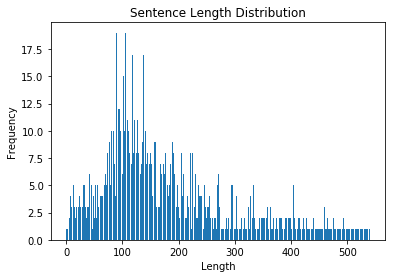

In [17]:
from collections import defaultdict

max_word_count_text = 0
text_count = defaultdict(int)
for sentence in train_ints:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [18]:
print('Max word sentence: %d' % max_word_count_text)

Max word sentence: 1305


Couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. Let's truncate to 200 steps. For reviews shorter than 200, we'll pad with 0s. For reviews longer than 200, we can truncate them to the first 200 characters.

Turns out its the final review that has zero length. But that might not always be the case, so let's make it more general.


In [19]:
#train_ints = [train_ints[ii] for ii in non_zero_idx]
#labels = np.array([labels[ii] for ii in non_zero_idx])

Now, create an array features that contains the data we'll pass to the network. The data should come from review_ints, since we want to feed integers to the network. Each row should be 200 elements long. For reviews shorter than 200 words, left pad with 0s. That is, if the review is ['best', 'movie', 'ever'], [117, 18, 128] as integers, the row will look like [0, 0, 0, ..., 0, 117, 18, 128]. For reviews longer than 200, use on the first 200 words as the feature vector.

In [20]:
seq_len = 200
features = sequence.pad_sequences(train_ints, maxlen = seq_len)

In [21]:

print('One sample')

print('Text: ')
print( train[2] )

print('Word sequence: ')
print( train_ints[2] )

print('Pad: ')
print( features[2] )

print('Label: ')
print( labels[2] )

del train

One sample
Text: 
Love it, love it, love it! This is another absolutely superb performance from the Divine Miss M. From the beginning to the end, this is one big treat! Don't rent it- buy it now!
Word sequence: 
[116, 9, 116, 9, 116, 9, 11, 6, 163, 404, 856, 239, 36, 1, 5839, 855, 2120, 36, 1, 427, 5, 1, 127, 11, 6, 27, 190, 1879, 87, 926, 9, 841, 9, 153]
Pad: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

# Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [22]:
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape)) 
print("Validation set: \t{}".format(val_x.shape))
print("Test set: \t\t{}".format(test_x.shape))

print("Train lable: \t\t{}".format(train_y.shape))


			Feature Shapes:
Train set: 		(1600, 200)
Validation set: 	(200, 200)
Test set: 		(200, 200)
Train lable: 		(1600, 2)


# Generate Lemmas 

In [23]:
'''
def lematizeFile(fileName):
    lex = []
    with open(fileName, 'r') as f:
        contains = f.readlines()
        for line in contains[:totalLinesToRead]:
            words = word_tokenize(line.decode('utf-8', 'replace'))
            lex += list(words)
    return [lemmatizer.lemmatize(i) for i in lex]
'''

"\ndef lematizeFile(fileName):\n    lex = []\n    with open(fileName, 'r') as f:\n        contains = f.readlines()\n        for line in contains[:totalLinesToRead]:\n            words = word_tokenize(line.decode('utf-8', 'replace'))\n            lex += list(words)\n    return [lemmatizer.lemmatize(i) for i in lex]\n"

In [24]:
# positiveLemmas = lematizeFile('./data/netflix-train-pos')
# negativeLemmas = lematizeFile('./data/netflix-train-neg')

In [25]:
# print("First lemma " + positiveLemmas[0])

In [26]:
#print("Positive lemmas: " + str(len(positiveLemmas)))
#print("Negative lemmas: " + str(len(negativeLemmas)))

In [27]:
#lemmas = positiveLemmas + negativeLemmas

## Lemmatize (take words repeats 50 < count < 1000)

In [28]:
#words = Counter(lemmas)
#vocabulary = []
#for word in words:
#    if 50 < words[word] < 1000:
#            vocabulary.append(word)

In [29]:
#print("Vocabulary: " + str(len(vocabulary)))
#print("Sample: " + vocabulary[0])

# Make One Hot Encoding features

In [30]:
'''
def samples(classif, lex, section):
    features = []
    with open(section, 'r') as file1:
        contents = file1.readlines()
        for line in contents[:totalLinesToRead]:
            words = word_tokenize(line.decode('utf-8', 'replace').lower())
            words = [lemmatizer.lemmatize(i) for i in words]
            feats = numpy.zeros(len(lex))
            for w in words:
                if w.lower() in lex:
                    index = lex.index(w.lower())
                    feats[index] += 1
            feats = list(feats)
            features.append([feats, classif])
            
    return features
'''

"\ndef samples(classif, lex, section):\n    features = []\n    with open(section, 'r') as file1:\n        contents = file1.readlines()\n        for line in contents[:totalLinesToRead]:\n            words = word_tokenize(line.decode('utf-8', 'replace').lower())\n            words = [lemmatizer.lemmatize(i) for i in words]\n            feats = numpy.zeros(len(lex))\n            for w in words:\n                if w.lower() in lex:\n                    index = lex.index(w.lower())\n                    feats[index] += 1\n            feats = list(feats)\n            features.append([feats, classif])\n            \n    return features\n"

In [31]:
#positive_features = samples([1,0], vocabulary, './data/netflix-train-pos')
#negative_features = samples([0,1], vocabulary, './data/netflix-train-neg')

In [32]:
#print("Positive features size: " + str(len(positive_features)))
#print("Negative features size: " + str(len(negative_features)))

##  Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [33]:
#features = positive_features + negative_features
#random.shuffle(features)
#features = np.array(features)

#testRation=0.1
#testSize = int(len(features)*testRation)
#training_positive = list(features[:,0][:-testSize])
#training_negative = list(features[:,1][:-testSize])

#testing_positive = list(features[:,0][-testSize:])
#testing_negative = list(features[:,1][-testSize:])



## Save to Pickle

In [34]:
#with open('sentiment_set.pickle', 'wb') as f:
#    pickle.dump([training_positive, training_negative, testing_positive, testing_negative], f)

## Create Sentiment Neural Network

In [35]:
def createModel(hidden_size, drop_size):
    model = Sequential()

    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(2, activation='sigmoid'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model




In [36]:
def createEmbeddedModel(hidden_size, drop_size):
    model = Sequential()
    
    model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = seq_len,
                     trainable = False,
                     name = 'embedding'))
    if drop_size > 0.0:
        model.add(Dropout(drop_size))
    
    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len, name="hidden_1"))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_2"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_3"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    model.add(Flatten())

    model.add(Dense(2, activation='sigmoid', name="output"))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

## Train model

In [37]:
batch_size = 100
epochs = 5

models = {}

models['model_200_drop_0.1'] = createModel(200, 0.1)
#models['model_400_drop_0.1'] = createModel(400, 0.1)
#models['model_600_drop_0.1'] = createModel(600, 0.1)
#models['model_200_no_drop'] = createModel(200, 0)
#models['model_400_no_drop'] = createModel(400, 0)
#models['model_600_no_drop'] = createModel(600, 0)

models['model_200_embedded'] = createEmbeddedModel(200, 0.1)

modes = [ 'model' ]
results = []
for name, model in models.items():  
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit(train_x, train_y,
              batch_size = batch_size,
              epochs = epochs,
              validation_data=(val_x, val_y))

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    print('Time: %d' % (end_time - start_time))


Start learning model_200_drop_0.1 at 1519849852
Epochs: 5
Batch size: 100
Train on 1600 samples, validate on 200 samples
Epoch 1/5
1600/1600 [==============================] - 1s 894us/step - loss: 8.2189 - acc: 0.4862 - val_loss: 7.1823 - val_acc: 0.5500
Epoch 2/5
1600/1600 [==============================] - 0s 275us/step - loss: 8.0787 - acc: 0.4959 - val_loss: 7.2136 - val_acc: 0.5500
Epoch 3/5
1600/1600 [==============================] - 1s 385us/step - loss: 8.1153 - acc: 0.4937 - val_loss: 7.2136 - val_acc: 0.5500
Epoch 4/5
1600/1600 [==============================] - 0s 180us/step - loss: 8.1153 - acc: 0.4937 - val_loss: 7.2136 - val_acc: 0.5500
Epoch 5/5
1600/1600 [==============================] - 0s 230us/step - loss: 8.1153 - acc: 0.4937 - val_loss: 7.2136 - val_acc: 0.5500
Time: 5

Start learning model_200_embedded at 1519849857
Epochs: 5
Batch size: 100
Train on 1600 samples, validate on 200 samples
Epoch 1/5
1600/1600 [==============================] - 36s 23ms/step - lo

In [38]:
for name, model in models.items():  
    
    score, acc = model.evaluate(test_x, test_y,
                                batch_size=batch_size)
    print('Model:', name)
    print('  Test score:', score)
    print('  Test accuracy:', acc)

200/200 [==============================] - 0s 416us/step
Model: model_200_drop_0.1
  Test score: 8.01512098312
  Test accuracy: 0.5
200/200 [==============================] - 1s 3ms/step
Model: model_200_embedded
  Test score: 0.521999508142
  Test accuracy: 0.752499997616


# Training Results

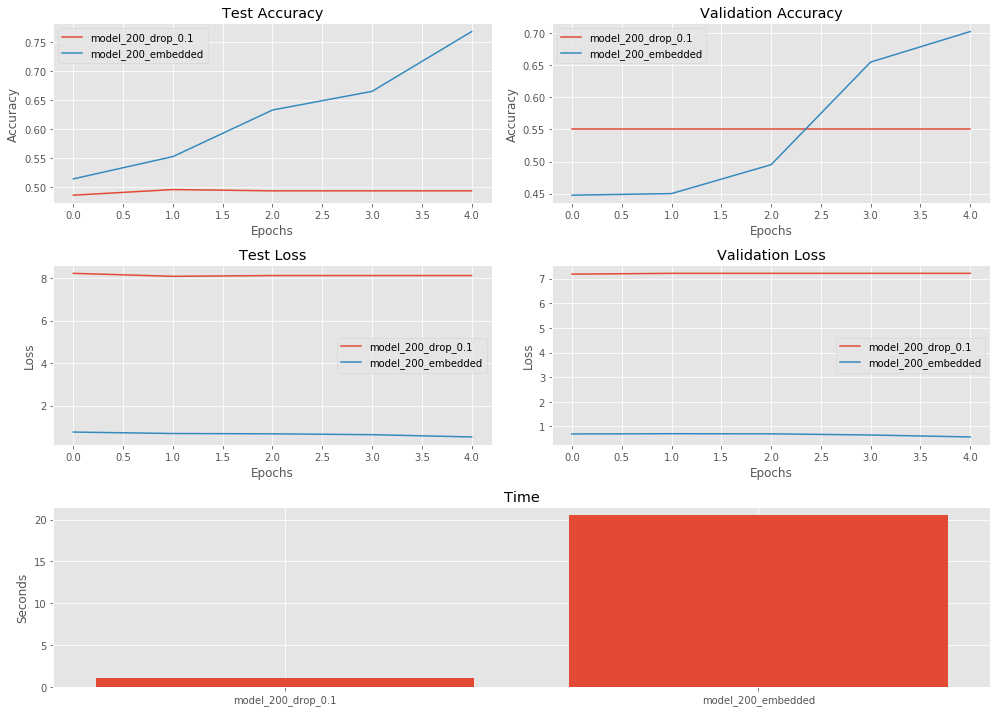

In [39]:

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Test Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Test Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.show()

In [40]:
'''
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500

n_classes = 2
batch_size = 100

x = tf.placeholder('float', [None, seq_len], name="inputs")
y = tf.placeholder('float', [None, 2], name="labels")

def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([seq_len, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes])),}


    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']

    return output

def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            
            i = 0
            while i < len(train_x):
                start = i
                end = i+batch_size
                batch_one = numpy.array(train_x[start:end])
                batch_two = numpy.array(train_y[start:end])
                
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_one, y: batch_two})
                epoch_loss += c
                i += batch_size

            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x: val_x, y: val_y}))

train_neural_network(x)

'''

'\nn_nodes_hl1 = 500\nn_nodes_hl2 = 500\nn_nodes_hl3 = 500\n\nn_classes = 2\nbatch_size = 100\n\nx = tf.placeholder(\'float\', [None, seq_len], name="inputs")\ny = tf.placeholder(\'float\', [None, 2], name="labels")\n\ndef neural_network_model(data):\n    hidden_1_layer = {\'weights\':tf.Variable(tf.random_normal([seq_len, n_nodes_hl1])),\n                      \'biases\':tf.Variable(tf.random_normal([n_nodes_hl1]))}\n\n    hidden_2_layer = {\'weights\':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),\n                      \'biases\':tf.Variable(tf.random_normal([n_nodes_hl2]))}\n\n    hidden_3_layer = {\'weights\':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),\n                      \'biases\':tf.Variable(tf.random_normal([n_nodes_hl3]))}\n\n    output_layer = {\'weights\':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),\n                    \'biases\':tf.Variable(tf.random_normal([n_classes])),}\n\n\n    l1 = tf.add(tf.matmul(data,hidden_1_layer[\'weigh

# Validation


In [41]:
'''
test_acc = []
with tf.Session(graph=graph) as sess:
     _, c = sess.run([optimizer, cost], feed_dict={x: test, y: batch_two})
     '''

'\ntest_acc = []\nwith tf.Session(graph=graph) as sess:\n     _, c = sess.run([optimizer, cost], feed_dict={x: test, y: batch_two})\n     '

## Using more data

In [42]:
'''
import io

def init_process(fin,fout):
    outfile = open(fout,'a')
    with io.open(fin, buffering=200000, encoding='latin-1') as f:
        try:
            for line in f:
                line = line.replace('"','')
                initial_polarity = line.split(',')[0]
                if initial_polarity == '0':
                    initial_polarity = [1,0]
                elif initial_polarity == '4':
                    initial_polarity = [0,1]

                tweet = line.split(',')[-1]
                outline = str(initial_polarity)+':::'+tweet
                outfile.write(outline)
        except Exception as e:
            print(str(e))
    outfile.close()
    '''

'\nimport io\n\ndef init_process(fin,fout):\n    outfile = open(fout,\'a\')\n    with io.open(fin, buffering=200000, encoding=\'latin-1\') as f:\n        try:\n            for line in f:\n                line = line.replace(\'"\',\'\')\n                initial_polarity = line.split(\',\')[0]\n                if initial_polarity == \'0\':\n                    initial_polarity = [1,0]\n                elif initial_polarity == \'4\':\n                    initial_polarity = [0,1]\n\n                tweet = line.split(\',\')[-1]\n                outline = str(initial_polarity)+\':::\'+tweet\n                outfile.write(outline)\n        except Exception as e:\n            print(str(e))\n    outfile.close()\n    '

## Uploading the new Sentiment140 data

In [43]:
'''
init_process('./data/training.1600000.processed.noemoticon.csv','train_set.csv')
init_process('./data/testdata.manual.2009.06.14.csv','test_set.csv')
'''

"\ninit_process('./data/training.1600000.processed.noemoticon.csv','train_set.csv')\ninit_process('./data/testdata.manual.2009.06.14.csv','test_set.csv')\n"